In [1]:
from keras.layers import Input, Dense, Lambda, Flatten, Activation, Merge, Concatenate, Add
from keras import layers
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
#import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
import tensorflow as tf

from models import vgg
from utils.angles import deg2bit, bit2deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, maad_from_deg, von_mises_log_likelihood_np
from utils.losses  import von_mises_log_likelihood_tf
from utils.towncentre import load_towncentre
from utils.experiements import get_experiment_id

Using TensorFlow backend.


#### TownCentre data

In [2]:
xtr, ytr_deg, xte, yte_deg = load_towncentre('data/TownCentre.pkl.gz', canonical_split=True)
image_height, image_width = xtr.shape[1], xtr.shape[2]
ytr_bit = deg2bit(ytr_deg)
yte_bit = deg2bit(yte_deg)

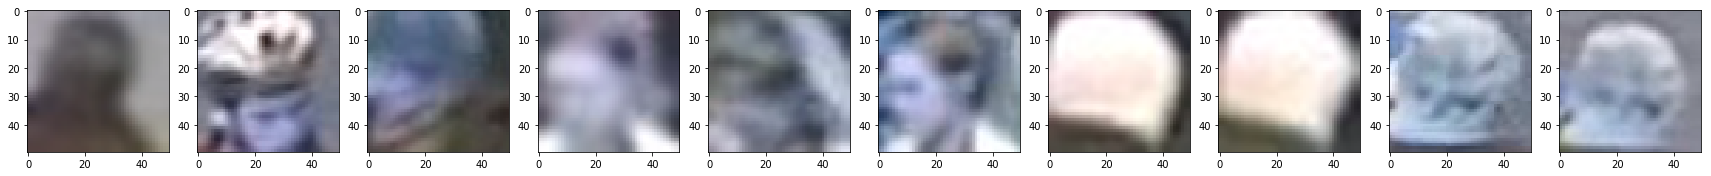

In [3]:
# fig, axs = plt.subplots(1, 10, figsize=(30, 15))
# for i in range(0, 10):
#     axs[i].imshow(xtr[i])

In [4]:
image_height, image_width, n_channels = xtr.shape[1:]
flatten_x_shape = xtr[0].flatten().shape[0]
phi_shape = yte_bit.shape[1]

#### Notation

$x$ - image,

$\phi$ - head angle,

$u$ - hidden variable

In [5]:
n_u = 8

In [6]:
X = Input(shape=[image_height, image_width, n_channels])
vgg_transformer = vgg.vgg_model(image_height=image_height, image_width=image_width)
X_vgg = vgg_transformer(X)
phi = Input(shape=[phi_shape])

#### Encoder network

$ q(u|x,\phi) \sim \mathcal{N}(\mu_1(x, \theta), \sigma_1(x, \theta)) $

In [7]:
# x_phi = concatenate([phi, Flatten()(X), ])
# We will usee VGG in final version
# x_vgg = vgg.vgg_model(image_height=image_height, image_width=image_width)(X)
x_phi = concatenate([X_vgg, phi])

encoder_hidden = Dense(512, activation='relu')(x_phi)

mu = Dense(n_u, activation='linear')(encoder_hidden)
log_sigma = Dense(n_u, activation='linear')(encoder_hidden)

In [8]:
encoder = Model(inputs=[X,phi], outputs=[mu])

In [9]:
encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 50, 50, 3)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 512)           922520      input_1[0][0]                    
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 514)           0           sequential_1[1][0]               
                                                                   input_2[0][0]           

#### Sample  $u \sim q(u|X,\phi)$

In [10]:
def sample_u(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=[n_u], mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps

u = Lambda(sample_u)([mu, log_sigma])

#### Decoder network

$p(\phi|u,x) \sim \mathcal{VM}(\mu(x,u,\theta''), 1) $

In [11]:
#x_u = concatenate([ Flatten()(X), u], axis=1) 
x_u = concatenate([ vgg_transformer(X), u], axis=1) 

In [12]:
n_x_vgg_shape = vgg_transformer(X).get_shape().as_list()[1]

In [13]:
decoder_model = Sequential()
decoder_model.add(Dense(512, activation='relu',input_shape=[n_x_vgg_shape + n_u]))
#decoder_model = vgg.vgg_model(image_height=image_height, image_width=image_width)

decoder_model.add(Dense(512, activation='relu',input_shape=[n_x_vgg_shape + n_u]))
decoder_model.add(Dense(2, activation='linear'))
decoder_model.add(Lambda(lambda x: K.l2_normalize(x,axis=1)))

In [15]:
#decoder_input = Input(shape=[n_x_vgg_shape+n_u])

decoder_input_x = Input(shape=[image_height, image_width, n_channels])
decoder_input_u = Input(shape=[n_u])
decoder_input = concatenate([vgg_transformer(decoder_input_x), decoder_input_u])

decoder_output = decoder_model(decoder_input)
decoder = Model([decoder_input_x, decoder_input_u], decoder_output)

In [ ]:
decoder.summary()

In [16]:
cvae_output = decoder_model(x_u)
cvae = Model(inputs=[X, phi], outputs=cvae_output)

In [21]:
cvae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 50, 50, 3)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 512)           922520      input_1[0][0]                    
                                                                   input_1[0][0]                    
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 514)           0           sequential_1[1][0]      

#### Define loss function

Current version assume $ p(u | x) \sim \mathcal{N}(0, 1)$

In [17]:
def cvae_loss(y_true, y_pred):
    """ Calculate loss = cosine loss + KL loss for each data in minibatch """
    # cosine loss
    regression = cosine_loss_tf(y_pred, y_true)
    #recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(u|X, phi) || P(u| phi)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    return regression + kl

#### Training

In [18]:
cvae.compile(optimizer='adadelta', loss=cvae_loss, metrics = ['cosine'])

In [ ]:
cvae.fit([xtr, ytr_bit], [ytr_bit], batch_size=10, epochs=200, validation_data=[[xte, yte_bit], yte_bit])

#### Predictions using decoder part

$ \phi_i = \mu(x_i,u_i,\theta'') $

In [24]:
n_samples = xte.shape[0]
ute = np.random.normal(0,1, [n_samples,n_u])

yte_preds_bit = decoder.predict([xte, ute])
yte_preds_deg = bit2deg(yte_preds_bit)

loss_te = maad_from_deg(yte_preds_deg, yte_deg)
mean_loss_te = np.mean(loss_te)
std_loss_te = np.std(loss_te)

print("MAAD error (test) : %f ± %f" % (mean_loss_te, std_loss_te))

kappa_preds_te = np.ones([xte.shape[0], 1]) 

log_likelihood_loss_te = von_mises_log_likelihood_np(yte_bit, yte_preds_bit, kappa_preds_te,
                                                     input_type='biternion')

print("log-likelihood (test) : %f" % log_likelihood_loss_te)

n_samples = xtr.shape[0]
utr = np.random.normal(0,1, [n_samples, n_u])
ytr_preds_bit = decoder.predict([xtr, utr])
ytr_preds_deg = bit2deg(ytr_preds_bit)

loss_tr = maad_from_deg(ytr_preds_deg, ytr_deg)
mean_loss_tr = np.mean(loss_tr)
std_loss_tr = np.std(loss_tr)

print("MAAD error (train) : %f ± %f" % (mean_loss_tr, std_loss_tr))

kappa_preds_tr = np.ones([xtr.shape[0], 1])

log_likelihood_loss_tr = von_mises_log_likelihood_np(ytr_bit, ytr_preds_bit, kappa_preds_tr,
                                                     input_type='biternion')

print("log-likelihood (train) : %f" % log_likelihood_loss_tr)

MAAD error (test) : 86.397621 ± 51.406892
log-likelihood (test) : -2.019080
MAAD error (train) : 85.605295 ± 51.616397
log-likelihood (train) : -2.006825
